# Pré Processing des données compteurs de vélo à Paris de 2018 à 2021 et recherche du Modele de Machine Learning adapté

In [1]:
# Import library:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import glob
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm, model_selection, neighbors, ensemble
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.4)
sns.set_style("whitegrid")

# Définition du chemin d'accès:
%cd Datas

C:\Users\Céline Doussot\Desktop\Data Analyst\Exams\Projet ParisPyVelib\ParisPyVelib\Datas


In [2]:
# Chargement du dataset et affichage des 2 première lignes
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')
df.head(2)

Unnamed: 0   Id  Count_by_hour        Date Date_instal  Source Direction  \
0           0  1.1            1.0  2018-01-01  2017-12-15    2018     NE-SO   
1           1  1.1            3.0  2018-01-01  2017-12-15    2018     NE-SO   

   Latitude  Longitude             Coord  ...  High_ice  Wind_speed_mean10mn  \
0    48.848      2.276  48.84800,2.27600  ...       0.0                  7.0   
1    48.848      2.276  48.84800,2.27600  ...       0.0                  7.0   

   City_meteo             Datetime  nom_jour_ferie  vacances_zone_c  \
0  Athis-Mons  2018-01-01 00:00:00     1er janvier             True   
1  Athis-Mons  2018-01-01 01:00:00     1er janvier             True   

       nom_vacances  Confinement_id                Address  \
0  Vacances de Noël            None  VOIE GEORGES POMPIDOU   
1  Vacances de Noël            None  VOIE GEORGES POMPIDOU   

                   Address_Dir  
0  VOIE GEORGES POMPIDOU NE-SO  
1  VOIE GEORGES POMPIDOU NE-SO  

[2 rows x 31 columns]

## 1. Exploration des données du dataset 2018-2021_comptage-velo-donnees-compteurs.csv

Pour que ce soit plus clair, on va definir pour chaque valeur des variables 'Dweek_Date_Count' et 'M_Date_Count' respectivement les jours et les mois.

In [3]:
# Remplacement des valeurs numérique par les jours de la semaine
df['Dweek_Date_Count'].replace({0: 'Lundi',
                                1: 'Mardi',
                                2: 'Mercredi',
                                3: 'Jeudi',
                                4: 'Vendredi',
                                5: 'Samedi',
                                6: 'Dimanche'}, inplace=True)

# Remplacement des valeurs numérique par les mois de l'année
df['M_Date_Count'].replace({1: 'Janvier',
                            2: 'Fevrier',
                            3: 'Mars',
                            4: 'Avril',
                            5: 'Mai',
                            6: 'Juin', 
                            7: 'Juillet',
                            8: 'Aout', 
                            9: 'Septembre', 
                            10: 'Octobre', 
                            11: 'Novembre',
                            12: 'Decembre'}, inplace=True)

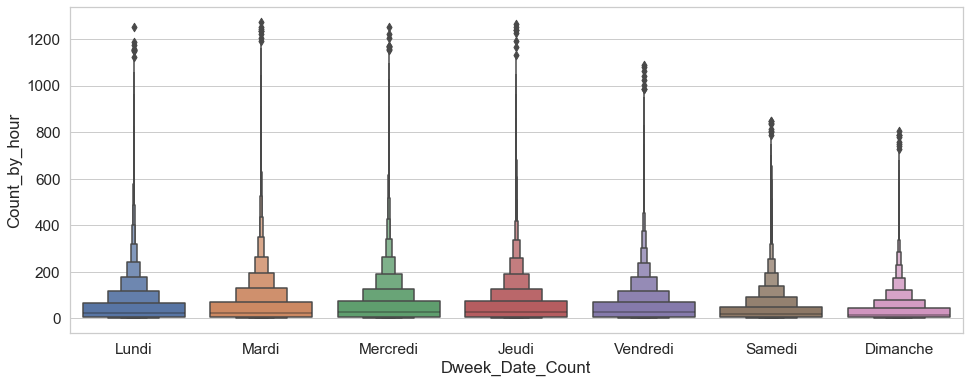

In [4]:
# Graphique de la repartition de la variable Count_by_hour representant le nombre de vélo compté chaque jour de la semaine
plt.figure(figsize=(16, 6))
sns.boxenplot(x='Dweek_Date_Count', y='Count_by_hour', data=df);

**Commentaire(s)** : 

* la distribution de la variable 'Count_by_hour' en fonction des jours de la semaine semble être homogène pour tous les jours de la semaine

**Prochaine étapes** : Selectionner le compteur qui comptabilise le plus de passage afin d'observer l'évolution de la variable *Count_by_hour* pendant une journée. L'objectif est de determiner si la variable *Count_by_hour* suit une distribution probabilistique connue.

## 2. Choix d'un compteur de référence

In [5]:
# Choix arbitraire d'une date pour observation des données
df040219 = df[df.M_Date_Count == 'Fevrier']
df040219 = df040219[df.D_Date_Count == 4]
df040219 = df040219[df.Y_Date_Count == 2019]

# Tableau croisé et tri descendant pour selectionné le compteur comptabilisant le plus de passage
pd.pivot_table(df040219, index='Address_Dir', aggfunc='sum').sort_values(by='Count_by_hour', ascending=False).head(3)

Count_by_hour  D_Date_Count  D_Date_Instal     HR%  \
Address_Dir                                                              
BD MAGENTA NO-SE           1847.0            96            672  1981.0   
BD MAGENTA SE-NO           1649.0            96            696  1981.0   
RUE LA FAYETTE E-O         1510.0            96            312  1981.0   

                    H_Date_Count  High_ice     Id  Latitude  Longitude  \
Address_Dir                                                              
BD MAGENTA NO-SE             276       0.0  326.4  1173.072     56.520   
BD MAGENTA SE-NO             276       0.0  321.6  1173.072     56.520   
RUE LA FAYETTE E-O           276       0.0   79.2  1173.072     56.424   

                    M_Date_Instal  Precip_last3h  Source   T°C  Unnamed: 0  \
Address_Dir                                                                  
BD MAGENTA NO-SE              264            0.5   48456  29.9    16121748   
BD MAGENTA SE-NO              264            0.5   48456  29.9    15596484   
RUE LA FAYETTE E-O             48            0.5   48456  29.9     3071556   

                    Wind_speed_mean10mn  Y_Date_Count  Y_Date_Instal  \
Address_Dir                                                            
BD MAGENTA NO-SE                   87.4         48456          48432   
BD MAGENTA SE-NO                   87.4         48456          48432   
RUE LA FAYETTE E-O                 87.4         48456          48288   

                    vacances_zone_c  
Address_Dir                          
BD MAGENTA NO-SE                  0  
BD MAGENTA SE-NO                  0  
RUE LA FAYETTE E-O                0

**Commentaire(s)** : Le compteur à l'adresse 89 boulevard de Magenta comptabilise le plus grand nombre de passage.

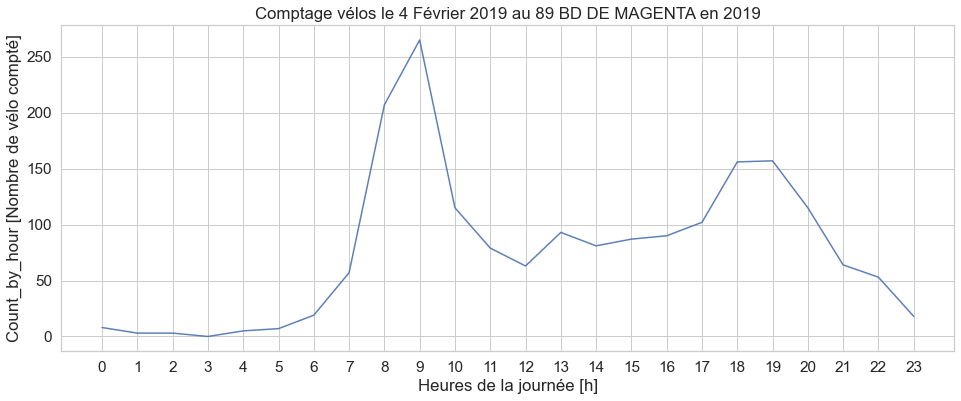

In [6]:
# Selection du compteur "89 BD DE MAGENTA"
df040219 = df040219[df.Address == "BD MAGENTA"]
df040219 = df040219[df.Direction == "NO-SE"]

# Affichage de la variable Count_by_hour en fonction des heures de la journée
plt.figure(figsize=(16, 6))
sns.lineplot(x='H_Date_Count', y='Count_by_hour', alpha=0.9, data=df040219)
plt.title('Comptage vélos le 4 Février 2019 au 89 BD DE MAGENTA en 2019')
plt.xlabel('Heures de la journée [h]')
plt.ylabel('Count_by_hour [Nombre de vélo compté]')
plt.xticks(np.arange(0, 24, 1));

**Commentaire(s)** : 

* On remarque bien deux mouvements un le matin et l'autre l'aprés-midi. l'évolution du nombre de vélo compté dans la journée ressemble à deux gaussiennes qui sont confondues.

**Prochaine étapes** : Essayons d'observer la densité de cette distribution

## 3. Étude statistiques

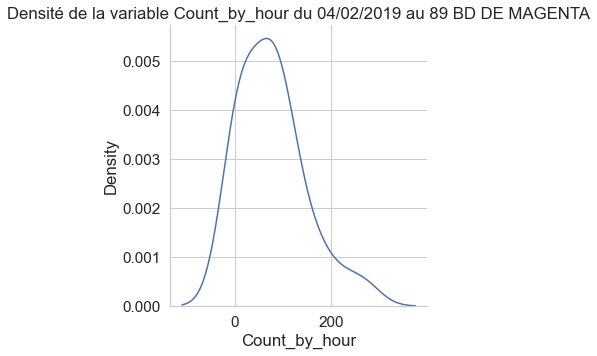

In [7]:
# Graphique de la densité de distribution pour la journée du 4 février 2019
sns.displot(x='Count_by_hour', kind='kde', data=df040219)
plt.title('Densité de la variable Count_by_hour du 04/02/2019 au 89 BD DE MAGENTA');

In [8]:
# Test statistique 
stat, p = shapiro(df040219['Count_by_hour'])
print(' Stat=%.3f, p-val=%.5f' % (stat, p))

 Stat=0.899, p-val=0.02021


**Commentaire(s)** : 

* La distribution ne suit pas une gaussienne. La p-value est inférieur à 5% donc la distribution de la variable *Count_by_hour* ne suit pas une loi Normale de 0h à 23h pour la journée du 4 février 2019.

**Prochaine étapes** : Est-ce que la distribution suit une loi Normal uniquement le matin et / ou l'aprés-midi ?

Pour la distribution du matin : Statistics=0.765, p=0.00273
Pour la distribution de l'aprés midi : Statistics=0.955, p=0.70315


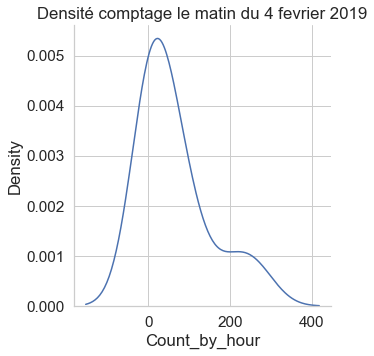

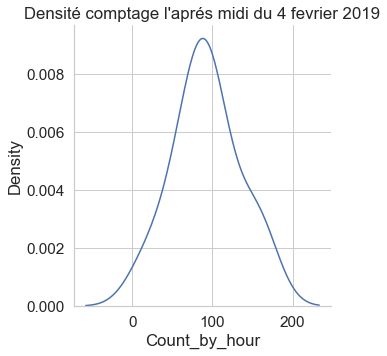

In [9]:
# séparation du dataframe : AM et PM
df040219AM = df040219[df.H_Date_Count <= 12]
df040219PM = df040219[(df040219['H_Date_Count'] > 12) & (df040219['H_Date_Count'] <=23)]

# Affichage des données pour le matin
sns.displot(x='Count_by_hour', kind='kde', data=df040219AM)
plt.title('Densité comptage le matin du 4 fevrier 2019');

# Affichage des donnés pour l'aprés-midi
sns.displot(x='Count_by_hour', kind='kde', data=df040219PM)
plt.title("Densité comptage l'aprés midi du 4 fevrier 2019");

# Test statistique AM
stat, p = shapiro(df040219AM['Count_by_hour'])
print('Pour la distribution du matin : Statistics=%.3f, p=%.5f' % (stat, p))

# Test statistique PM
stat, p = shapiro(df040219PM['Count_by_hour'])
print("Pour la distribution de l'aprés midi : Statistics=%.3f, p=%.5f" % (stat, p))

**Commentaire(s)** : 

* On à une p-value supérieur à 5% pour l'aprés midi, toutefois ce n'est pas vraiment le cas le matin. 

**Prochaine étapes** : Essayons maintenant d'observer si tous les autres jours de la semaine au mois de février, présentent les mêmes formes de distribution ?

<Figure size 864x432 with 0 Axes>

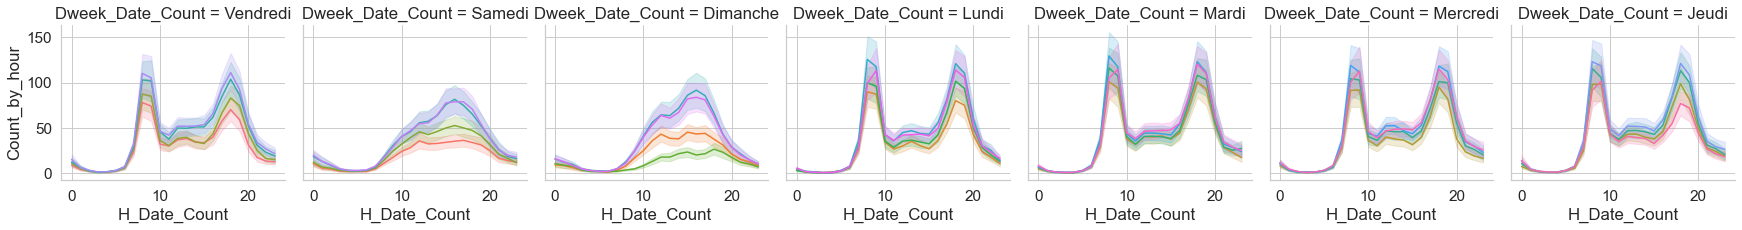

In [10]:
# Selection des données uniquement pour le mois de Février
df_Fev19 = df[df.M_Date_Count == 'Fevrier']
df_Fev19 = df_Fev19[df_Fev19.Y_Date_Count == 2019]

# Affichage des données
plt.figure(figsize=(12, 6))
g = sns.FacetGrid(data=df_Fev19, col="Dweek_Date_Count", hue='D_Date_Count', height=3.5)
g.map(sns.lineplot, "H_Date_Count", "Count_by_hour");

**Commentaire(s)** : 

* On observe que le samedi et le dimanche n'ont pas les mêmes horaires d'affluence

**Prochaine étapes** : Et le reste de l'année 2019 ?

<Figure size 576x432 with 0 Axes>

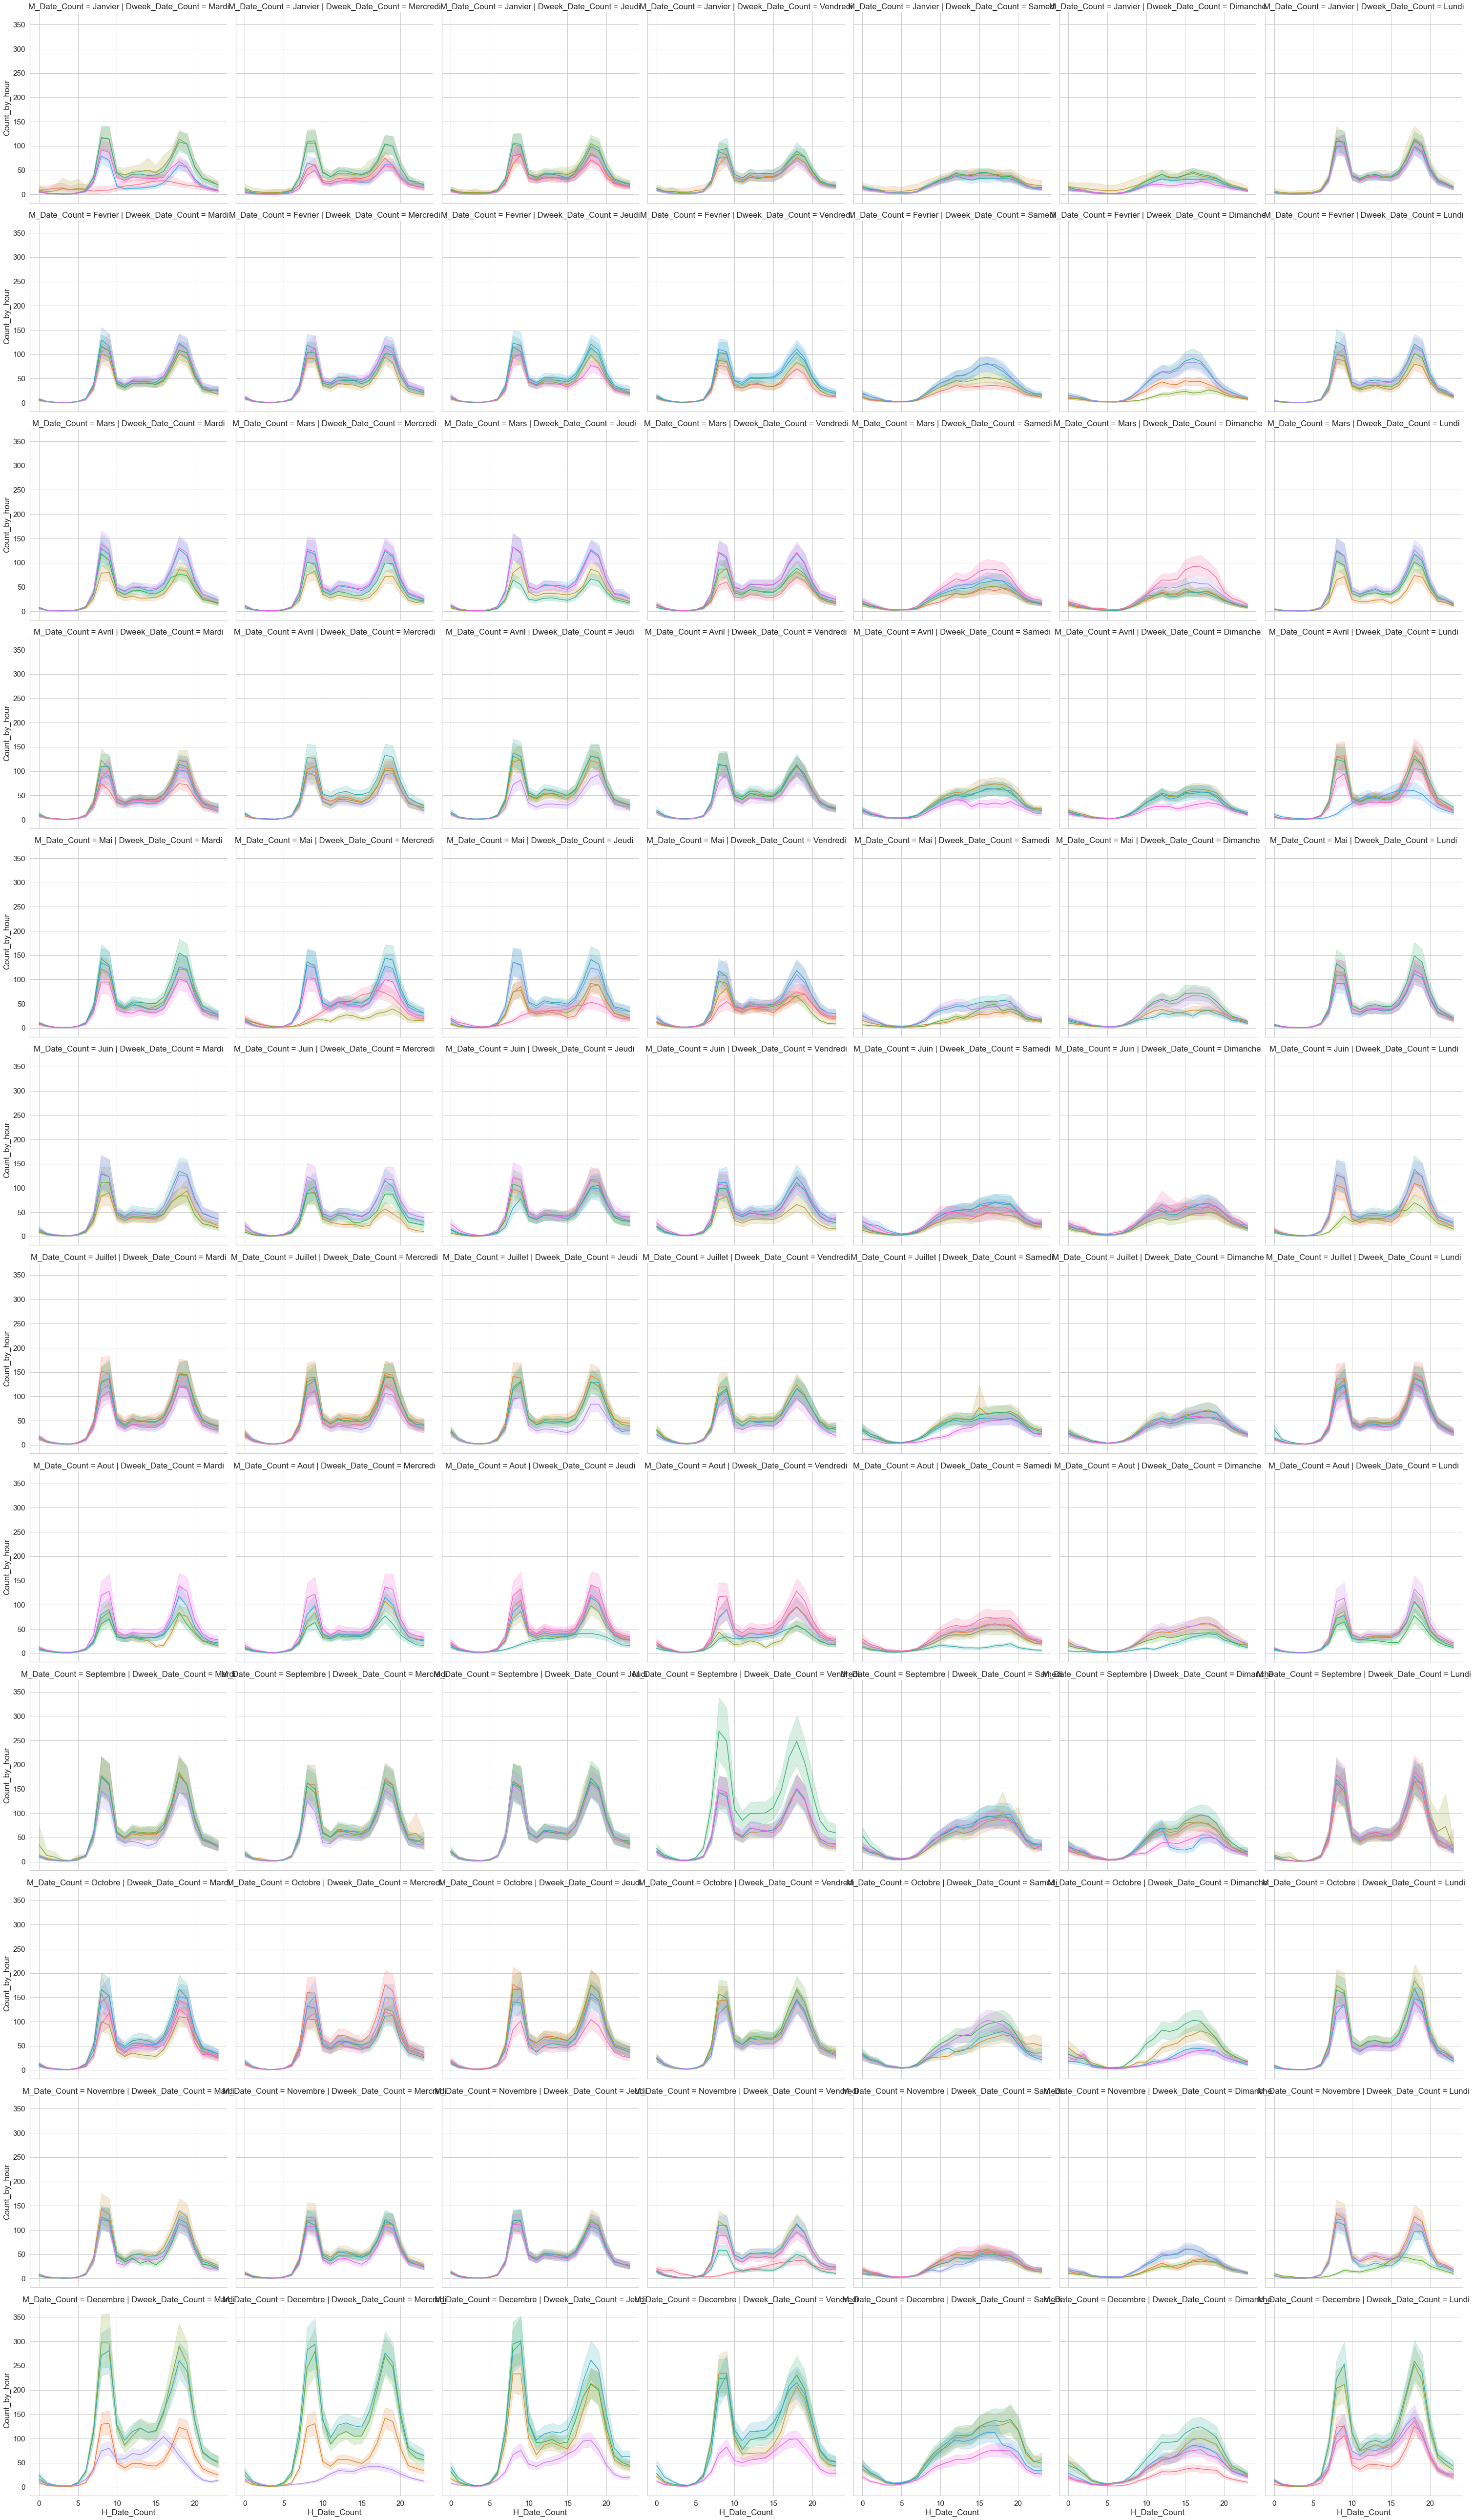

In [11]:
# Selection des données uniquement pour l'année 2019
df_2019 = df[df.Y_Date_Count == 2019]

# Affichage des données
plt.figure(figsize=(8, 6))
g = sns.FacetGrid(data=df_2019, row = 'M_Date_Count', col="Dweek_Date_Count", hue='D_Date_Count', height=6)
g.map(sns.lineplot, "H_Date_Count", "Count_by_hour");

**Commentaire(s)** : 

* C'est aussi le cas pour tout le reste de l'année pour le samedi et dimanche. On a malgré tous quelques jours particuliers qui se distinguent avec une distribution des valeurs nettement différentes. Certainement des jours fériés, événements particuliers ou autres.

**Prochaine étapes** : Faire un test statistique pour chaque demi-journée afin de vérifier si le modèle gaussien peut s'appliquer

In [12]:
# Fonction am ou pm pour définir selon l'horaire la matinée ou l'aprés-midi
def amORpm(row):
    if row['H_Date_Count'] <= 12:
        val = 'AM'
    else:
        val = 'PM'
    return val

# Duplication de la colonne H_Date_Count
df['AM_PM'] = df['H_Date_Count'] 

# Application de la fonction amORpm
df['AM_PM'] = df.apply(amORpm, axis=1)

In [13]:
# Suppréssion des colonnes non utiles
dfg = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Date',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal', 'H_Date_Count'], axis = 1)

# Séparation des données de la colonne Date_count
dfg[['Date','Hour']] = df.Datetime.str.split(" ", expand=True)

In [14]:
# Création de la liste de toutes les adresses des compteurs
listOfAdress = dfg['Address'].unique()

# Création d'un df pour les données de test statistique pour le matin
dfStatTesAM = pd.DataFrame(columns=['Address', 'Date', 'stat', 'p-val'])

# Création d'un df pour les données de test statistique pour l'aprés-midi
dfStatTesPM = pd.DataFrame(columns=['Address', 'Date', 'stat', 'p-val'])

for element in listOfAdress:
    # Chaque element est une adresse de compteur
    temp_df = dfg[dfg.Address == element]

    # On cherche les date pour le df temporaire du compteur en cours
    listOfDate = temp_df['Date'].unique()    
    
    
    # Pour chaque l'adresse on cherche les valeurs unique de dates
    for date in listOfDate:
        temp_df = temp_df[temp_df.Date == date]
              
        
    # Enregistrement des valeurs statistique pour le matin uniquement
        temp_df1 = temp_df[temp_df.AM_PM == 'AM']
               
        if temp_df1.shape[0] != 0 and temp_df1.shape[0] > 3:
            stat, p = shapiro(temp_df1['Count_by_hour'])
            
            dfStatTesAM = dfStatTesAM.append({'Address':element, 
                                              'Date': date, 
                                              'Stat': stat, 
                                              'p_val': p}, ignore_index=True)
        
    # Enregistrement des valeurs statistique pour l'aprés-midi uniquement
        temp_df2 = temp_df[temp_df.AM_PM == 'PM']
        
        if temp_df2.shape[0] != 0 and temp_df2.shape[0] > 3:
            stat, p = shapiro(temp_df2['Count_by_hour'])
            
            dfStatTesPM = dfStatTesPM.append({'Address':element, 
                                              'Date': date, 
                                              'Stat': stat, 
                                              'p_val': p}, ignore_index=True)
            
    # Reset de temp_df sur l'adresse du compteur
            temp_df = dfg[dfg.Address == element]

On dénombre 6439 p-value inférieur à 5% et 1051 supérieur à 5%


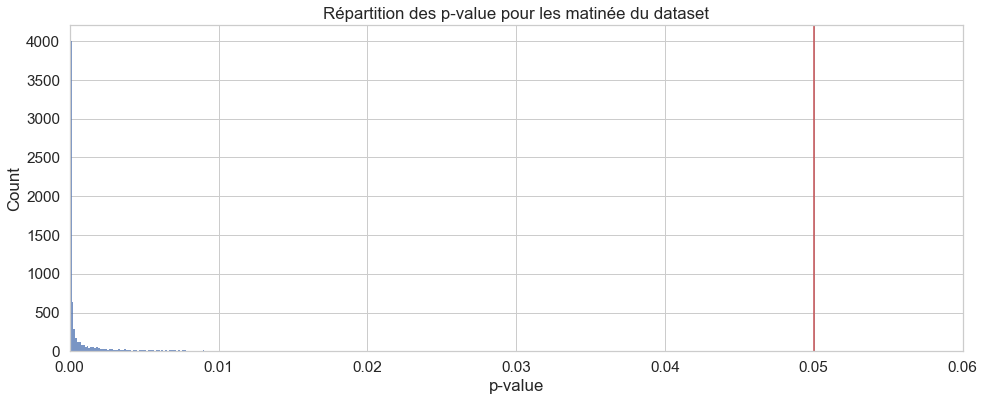

In [15]:
# Selection des p-value supérieur et inférieur à 5% pour le matin
NbPvalUnder = dfStatTesAM[dfStatTesAM.p_val < 0.005]
NbPvalUpper = dfStatTesAM[dfStatTesAM.p_val >= 0.005]

# Affichage des données
plt.figure(figsize=(16, 6))
sns.histplot(data=dfStatTesAM, x="p_val")
plt.title('Répartition des p-value pour les matinée du dataset')
plt.xlabel('p-value')
plt.axvline(0.05, color ='r')
plt.xlim(0, 0.06);

print('On dénombre',NbPvalUnder.shape[0], 'p-value inférieur à 5% et',NbPvalUpper.shape[0], 'supérieur à 5%')

On dénombre 1586 p-value inférieur à 5% et 5904 supérieur à 5%


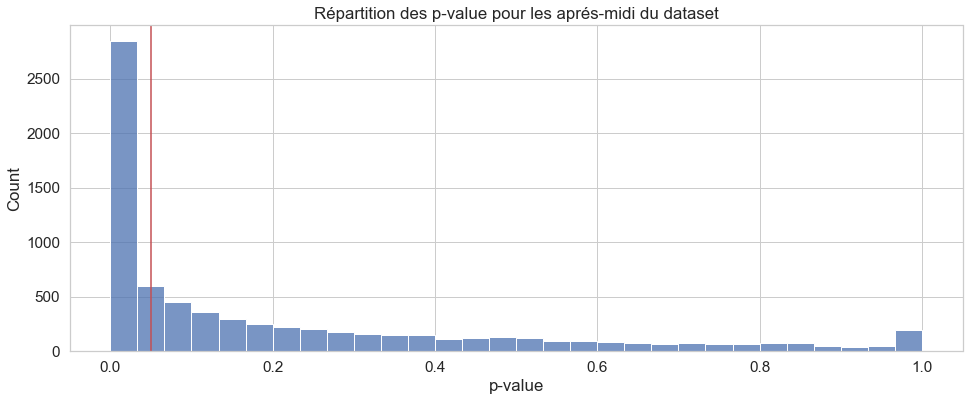

In [16]:
# Selection des p-value supérieur et inférieur à 5% pour l'aprés midi
NbPvalUnder = dfStatTesPM[dfStatTesPM.p_val < 0.005]
NbPvalUpper = dfStatTesPM[dfStatTesPM.p_val > 0.005]

plt.figure(figsize=(16, 6))
sns.histplot(data=dfStatTesPM, x="p_val")
plt.title('Répartition des p-value pour les aprés-midi du dataset')
plt.xlabel('p-value')
plt.axvline(0.05, color ='r');

print('On dénombre',NbPvalUnder.shape[0], 'p-value inférieur à 5% et',NbPvalUpper.shape[0], 'supérieur à 5%')

## 4. Conclusion aprés observations des données et étude statistiques

* La tendance observée pour la journée du 4 février 2019 se confirme sur les autres dates et compteurs. Le nombre de p-value supérieur à 5% est plus important pour l'après-midi comparé au nombre du matin.

* Les p-value calculé pour le matin et l'après-midi ne permettent pas de définir une loi Normale pour modéliser le comptage des vélos. Si l'on souhaite prévoir le nombre de vélos pour chaque compteur, il est préférable d'entrainer un modèle et d'en vérifier les performances afin de prédire au mieux le comptage des vélos pour chaque site.

## 5. Pre Processing ET choix du modèle de Machine Learning

In [17]:
# chargement du dataset
df = pd.read_csv('2018-2021_donnees-velib-meteo_hour.csv')
# etendue des valeurs pour les na
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

In [18]:
# Selection d'un seul compteur et uniquement pour l'année 2021
df = df[df.Address == "BD MAGENTA"]
df = df[df.Direction == "NO-SE"]
df = df[df.Y_Date_Count == 2021 ]

# Supression des colonnes non utile pour le modele
df = df.drop(['Unnamed: 0', 'Coord', 'City_meteo', 'vacances_zone_c', 'Address', 'Date', 'Address_Dir',
              'Source', 'Id', 'Y_Date_Instal', 'M_Date_Instal', 'D_Date_Instal', 'Date_instal', 'H_Date_Count'], axis = 1)

# Split des colonne de date et heure
df[['Date','Time']] = df['Datetime'].str.split(' ',expand=True)
df = df.drop(['Date'], axis=1)
df[['hh','mm', 'ss' ]] = df['Time'].str.split(':',expand=True)
df = df.drop(['Time','Datetime', 'mm', 'ss'], axis=1)
df['hh'] = df.hh.astype('int64')

# Ajout de la variable AP et PM
df['AM_PM'] = ['AM' if x < 12 else 'PM' for x in df['hh']]

# Ajout de la variable weekend et week
df['week_day_type'] = ['week' if x < 5 else 'weekend' for x in df['Dweek_Date_Count']]

# Reset de l'index
df = df.reset_index(drop=True)

# List des variable catégorielle
cat_df = df.select_dtypes(include='object')
cat_df = cat_df.columns.tolist()

# Transformation des variable catégorielle en variable indicatrices
df = pd.get_dummies(df, columns=cat_df)

# Affichage des 5 première lignes du df
df.head()

Count_by_hour  Latitude  Longitude  Y_Date_Count  M_Date_Count  \
0            1.0    48.878      2.355          2021             1   
1            6.0    48.878      2.355          2021             1   
2            5.0    48.878      2.355          2021             1   
3            7.0    48.878      2.355          2021             1   
4            6.0    48.878      2.355          2021             1   

   D_Date_Count  Dweek_Date_Count  T°C  Precip_last3h   HR%  ...  \
0             1                 4  1.1            0.0  92.0  ...   
1             1                 4 -0.4            0.0  96.0  ...   
2             1                 4 -0.4            0.0  96.0  ...   
3             1                 4 -0.4            0.0  96.0  ...   
4             1                 4 -1.9            0.0  98.0  ...   

   nom_vacances_Pont de l'Ascension  nom_vacances_Vacances d'hiver  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   

   nom_vacances_Vacances de Noël  nom_vacances_Vacances de printemps  \
0                              1                                   0   
1                              1                                   0   
2                              1                                   0   
3                              1                                   0   
4                              1                                   0   

   Confinement_id_Confinement 3  Confinement_id_None  AM_PM_AM  AM_PM_PM  \
0                             0                    1         1         0   
1                             0                    1         1         0   
2                             0                    1         1         0   
3                             0                    1         1         0   
4                             0                    1         1         0   

   week_day_type_week  week_day_type_weekend  
0                   1                      0  
1                   1                      0  
2                   1                      0  
3                   1                      0  
4                   1                      0  

[5 rows x 32 columns]

In [19]:
# Selection de la target et des feats
target = df['Count_by_hour']
feats = df.drop(['Count_by_hour'], axis=1)

In [20]:
# Vérification du type des variables pour les features
feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Latitude                            3575 non-null   float64
 1   Longitude                           3575 non-null   float64
 2   Y_Date_Count                        3575 non-null   int64  
 3   M_Date_Count                        3575 non-null   int64  
 4   D_Date_Count                        3575 non-null   int64  
 5   Dweek_Date_Count                    3575 non-null   int64  
 6   T°C                                 3575 non-null   float64
 7   Precip_last3h                       3575 non-null   float64
 8   HR%                                 3575 non-null   float64
 9   High_ice                            3575 non-null   float64
 10  Wind_speed_mean10mn                 3575 non-null   float64
 11  hh                                  3575 no

In [21]:
# On récupère les valeurs des classes
pd.qcut(target, 4)
# [(-0.001, 19.0] < (19.0, 119.0] < (119.0, 227.0] < (227.0, 585.0]]

0       (-0.001, 19.0]
1       (-0.001, 19.0]
2       (-0.001, 19.0]
3       (-0.001, 19.0]
4       (-0.001, 19.0]
             ...      
3570    (227.0, 585.0]
3571    (227.0, 585.0]
3572    (119.0, 227.0]
3573     (19.0, 119.0]
3574     (19.0, 119.0]
Name: Count_by_hour, Length: 3575, dtype: category
Categories (4, interval[float64]): [(-0.001, 19.0] < (19.0, 119.0] < (119.0, 227.0] < (227.0, 585.0]]

In [22]:
# Classification de la varibale Target
target = pd.qcut(target, 4, labels = [0, 1, 2, 3])

In [23]:
# Séparation du jeux de donnée pour entrainement
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=101)

In [24]:
# Preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = X_train
X_test_scaled = X_test

### Modèle : SVM

In [25]:
# Création d'un classifieur clf sans paramètres
clf = svm.SVC()

# Entrainement de l'algorithme sur l'ensemble d'entrainement
clf.fit(X_train_scaled, y_train)

# Recherche des meilleurs hyperparamètres
parametres = {'C':[0.1,1,10,50], 'kernel':['rbf','linear']}
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)
grille = grid_clf.fit(X_train_scaled,y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print('Le modèle qui fournit la meilleur prédiction à pour paramètres :',grid_clf.best_params_)

                           params  mean_test_score
0     {'C': 0.1, 'kernel': 'rbf'}         0.259790
1  {'C': 0.1, 'kernel': 'linear'}         0.567483
2       {'C': 1, 'kernel': 'rbf'}         0.259790
3    {'C': 1, 'kernel': 'linear'}         0.573776
4      {'C': 10, 'kernel': 'rbf'}         0.377972
5   {'C': 10, 'kernel': 'linear'}         0.561538
6      {'C': 50, 'kernel': 'rbf'}         0.442657
7   {'C': 50, 'kernel': 'linear'}         0.560490
Le modèle qui fournit la meilleur prédiction à pour paramètres : {'C': 1, 'kernel': 'linear'}


In [26]:
# Prédiction des features test et création de la matrice de confusion
clf = svm.SVC(C=1, kernel='linear')
clf.fit(X_train_scaled, y_train)

# Matrice de confusion
y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite    0   1   2    3
Classe réelle                   
0               142  22   0    7
1                43  89  26   12
2                 7  67  65   51
3                11  35  36  102

**Commentaire(s)** : 

* Le modèle SVM n'est pas assez performant

### Modèle : KNN

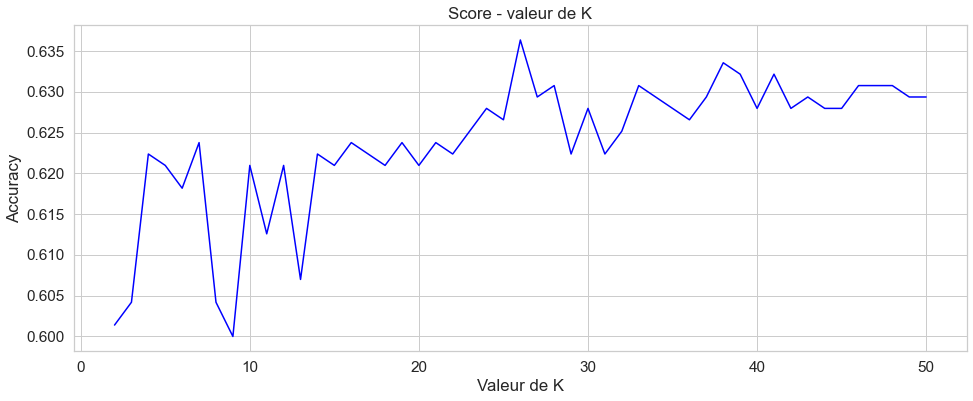

In [27]:
# Création liste de score
score=[]

# Test des valeurs de K
for k in range(2, 51):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    score.append(knn.score(X_test_scaled, y_test))

# Affichage de la précision en fonction de la valeur de K
plt.figure(figsize=(16,6))
plt.plot(range(2, 51), score, color='blue')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy')
plt.grid('--');

**Commentaire(s)** : 

* Le modèle KNN n'est pas assez performant

### Modèle : Random Forest

In [28]:
# Création d'un classifieur
clf = ensemble.RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [29]:
# Recherche des meilleurs hyperparamètres
parametres = {'max_features':[None], 'min_samples_split':list(range(2, 32, 2))}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

grille = grid_clf.fit(X_train_scaled,y_train)

print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])
print('Le modèle qui fournit la meilleur prédiction à pour paramètres :',grid_clf.best_params_)

                                             params  mean_test_score
0    {'max_features': None, 'min_samples_split': 2}         0.818531
1    {'max_features': None, 'min_samples_split': 4}         0.820979
2    {'max_features': None, 'min_samples_split': 6}         0.821678
3    {'max_features': None, 'min_samples_split': 8}         0.823776
4   {'max_features': None, 'min_samples_split': 10}         0.827273
5   {'max_features': None, 'min_samples_split': 12}         0.825175
6   {'max_features': None, 'min_samples_split': 14}         0.829371
7   {'max_features': None, 'min_samples_split': 16}         0.825524
8   {'max_features': None, 'min_samples_split': 18}         0.824126
9   {'max_features': None, 'min_samples_split': 20}         0.824126
10  {'max_features': None, 'min_samples_split': 22}         0.825524
11  {'max_features': None, 'min_samples_split': 24}         0.824126
12  {'max_features': None, 'min_samples_split': 26}         0.819930
13  {'max_features': None, 'min_sa

In [30]:
# Prédiction des features test et création de la matrice de confusion
clf = ensemble.RandomForestClassifier(min_samples_split=12)
clf.fit(X_train_scaled, y_train)

y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite    0    1    2    3
Classe réelle                     
0               156   15    0    0
1                 8  148   14    0
2                 0   16  141   33
3                 0    0   33  151

**Commentaire(s)** : 

* Le modèle Random Forest est suffisamment performant. Ce modèle est donc sélectionné pour prédire le nombre de vélos compté par heure.

## 6. Prédiction avec Random Forest

In [31]:
# Définition des sliders de selection Mois et Jours
Month = widgets.IntSlider(value=2,
    min=1,
    max=12,
    step=1,
    description='Month :',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d', layout=widgets.Layout(width='100%'))

Day = widgets.IntSlider(value=2,
    min=1,
    max=31,
    step=1,
    description='Day :',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d', layout=widgets.Layout(width='100%'))

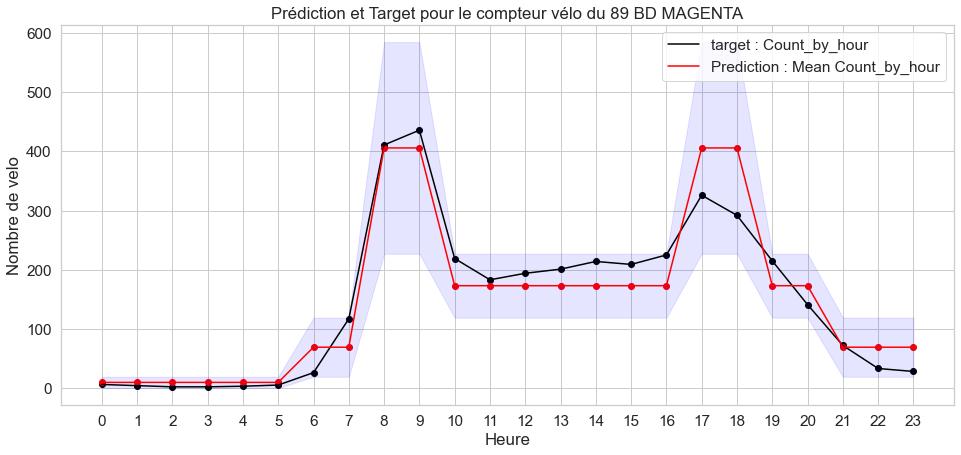

In [32]:
# Selection de la date
df_Select = df[df.M_Date_Count == Month.value]
df_Select = df_Select[df_Select.D_Date_Count == Day.value]

# Selection de la target et des feats
target_to_predict = df_Select['Count_by_hour']
feats_to_predict = df_Select.drop(['Count_by_hour'], axis=1)

# Calul des prédiction
prediction = clf.predict(feats_to_predict)

# Création d'une liste avec les moyennes des classes et remplacement des moyennes dans le resultat des prédictions
lmc = [9.5, 69, 173, 406]
lmin = [0, 19, 119, 227]
lmax = [19, 119, 227, 585]
pred = []
pred_min = []
pred_max = []

for classes in prediction:
    if classes == 0:
        pred.append(lmc[0])
        pred_min.append(lmin[0])
        pred_max.append(lmax[0])
    if classes == 1:
        pred.append(lmc[1])
        pred_min.append(lmin[1])
        pred_max.append(lmax[1])
    if classes == 2:
        pred.append(lmc[2])
        pred_min.append(lmin[2])
        pred_max.append(lmax[2])
    if classes == 3:
        pred.append(lmc[3]) 
        pred_min.append(lmin[3])
        pred_max.append(lmax[3])
        
# Graphique du compteur et des prédiction      
plt.figure(figsize=(16,7))

# Graph du compteur horaire
plt.plot(df_Select['hh'],df_Select['Count_by_hour'],color='black')
plt.scatter(df_Select['hh'],df_Select['Count_by_hour'],color='black')

# Graph des prédiction
plt.plot(df_Select['hh'], pred, color='red')
plt.scatter(df_Select['hh'], pred, color='red')

# Ajout de la valeur max et min de chaque classes prédites comme contours
plt.fill_between(df_Select['hh'], pred_min, pred_max, alpha=0.1, color="blue")

plt.xlabel('Heure')
plt.ylabel('Nombre de velo')
plt.legend(['target : Count_by_hour', 'Prediction : Mean Count_by_hour'])
plt.title('Prédiction et Target pour le compteur vélo du 89 BD MAGENTA')

plt.grid('--')
plt.xticks(np.arange(0, 24, 1));

In [33]:
# Affichage des sliders
display(Month, Day)

# Aprés avoir selectionner les valeurs dans chaque slider, executer la cellule précedente pour mettre à jour le graphique #

IntSlider(value=2, continuous_update=False, description='Month :', layout=Layout(width='100%'), max=12, min=1)

IntSlider(value=2, continuous_update=False, description='Day :', layout=Layout(width='100%'), max=31, min=1)

## Conclusion : 

Le modèle Random Forest prédit la target *Count_by_hour* avec une précision de 80%. Ce modèle de Machine Learning est le plus précis pour prédire le nombre de vélos compté par heure. 